In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# 幕后：训练数字分类器

在第二章中，我们已经看到了实际训练各种模型的样子，现在让我们来深入了解一下到底发生了什么。我们将通过计算机视觉来介绍深度学习的基本工具和概念。

准确地说，我们将讨论数组和张量以及广播的作用，这是一种使用它们表达力的强大技术。我们将解释随机梯度下降（SGD），这是一种通过自动更新权重学习的机制。我们将讨论在我们的基本分类任务中选择损失函数的问题，以及小批量的作用。我们还将描述基本神经网络实际上正在执行的数学运算。最后，我们将把所有这些组件放在一起。

在未来的章节中，我们还将深入探讨其他应用，并看到这些概念和工具是如何泛化的。但是，这一章是关于奠定基础的。坦率地说，这也使得这一章成为最困难的章节之一，因为这些概念彼此相互依赖。就像一座拱门，所有的石头都需要放在正确的位置才能支撑住结构。同样，一旦这种情况发生，它将成为一个强大的结构，可以支持其他事物。但是，组装起来需要一些耐心。

让我们开始吧。第一步是考虑图像在计算机中的表示方式。

## 像素：计算机视觉的基础

为了理解计算机视觉模型中发生的事情，我们首先必须了解计算机如何处理图像。我们将使用计算机视觉中最著名的数据集之一，[MNIST](https://en.wikipedia.org/wiki/MNIST_database)，进行实验。MNIST包含手写数字的图像，由美国国家标准与技术研究所收集，并由Yann Lecun及其同事整理成一个机器学习数据集。1998年，Lecun在[Lenet-5](http://yann.lecun.com/exdb/lenet/)中使用了MNIST，这是第一个能够实现实用的手写数字序列识别的计算机系统。这是人工智能历史上最重要的突破之一。

## 侧边栏：坚韧和深度学习

深度学习的故事是一群专注的研究人员坚韧不拔、勇往直前的故事。在早期的希望和炒作之后，神经网络在1990年代和2000年代失宠了，只有少数几个研究人员一直努力使它们表现良好。其中三位，Yann Lecun、Yoshua Bengio和Geoffrey Hinton，在广泛的机器学习和统计学界对它们持深刻怀疑和不感兴趣的情况下，最终获得了计算机科学中最高荣誉——图灵奖（通常被认为是计算机科学的“诺贝尔奖”），并于2018年获奖。

Geoff Hinton讲述了即使是表现出远远优于以往任何已发表的结果的学术论文也会因为使用了神经网络而被顶级期刊和会议拒绝的故事。Yann Lecun在卷积神经网络上的工作（我们将在下一节中学习）表明，这些模型可以阅读手写文本——这是以前从未实现过的。然而，尽管它被商业上用于阅读美国10%的支票，但他的突破被大多数研究人员忽视了！

除了这三位图灵奖得主之外，还有许多其他研究人员为我们今天的成就奋斗过。例如，许多人认为应该与图灵奖共享的Jurgen Schmidhuber开创了许多重要的思想，包括与他的学生Sepp Hochreiter合作开发的长短期记忆（LSTM）架构（广泛用于语音识别和其他文本建模任务，并在<<chapter_intro>>中的IMDb示例中使用）。也许最重要的是，Paul Werbos于1974年发明了神经网络的反向传播技术，这是本章展示的技术，并被普遍用于训练神经网络（[Werbos 1994](https://books.google.com/books/about/The_Roots_of_Backpropagation.html?id=WdR3OOM2gBwC)）。他的发明几乎被完全忽视了几十年，但今天被认为是现代人工智能最重要的基础之一。

这里对我们所有人都有一个教训！在你的深度学习之旅中，你将面临许多障碍，包括技术上的障碍，以及（更加困难的）来自身边不相信你会成功的人的挑战。有一种*保证*会失败的方式，那就是停止努力。我们已经看到，每一个成为世界一流实践者的fast.ai学生中唯一一致的特征是他们都非常坚韧。

## 结束侧边栏

对于这个初始教程，我们只是尝试创建一个能够将任何图像分类为3或7的模型。所以让我们下载一个MNIST的样本，其中只包含这些数字的图像：

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
#hide
Path.BASE_PATH = path

我们可以使用`ls`来查看此目录中的内容，这是fastai添加的一个方法。该方法返回一个特殊的fastai类对象`L`，它具有与Python内置的`list`相同的所有功能，以及更多功能。其中一个方便的功能是，当打印时，它会显示项目的计数，然后列出项目本身（如果项目超过10个，它只会显示前几个）：

In [ ]:
path.ls()

(#9) [Path('cleaned.csv'),Path('item_list.txt'),Path('trained_model.pkl'),Path('models'),Path('valid'),Path('labels.csv'),Path('export.pkl'),Path('history.csv'),Path('train')]

MNIST数据集遵循机器学习数据集的常见布局：训练集和验证集（和/或测试集）分别放在不同的文件夹中。让我们看看训练集里面有什么：

In [ ]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

这里有一个包含3的文件夹，和一个包含7的文件夹。在机器学习术语中，我们说"3"和"7"是这个数据集中的*标签*（或目标）。让我们查看其中一个文件夹里的内容（使用`sorted`确保我们得到相同的文件顺序）：

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

正如我们所预期的那样，这里充满了图像文件。现在让我们来看一个。这是来自著名的MNIST手写数字数据集的一个手写数字3的图像：

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

我们在这里使用了 *Python Imaging Library*（PIL）中的 `Image` 类，它是最广泛使用的用于打开、操作和查看图像的Python包。Jupyter知道PIL图像，因此会自动为我们显示图像。

在计算机中，所有内容都以数字表示。要查看构成此图像的数字，我们必须将其转换为 *NumPy 数组* 或 *PyTorch 张量*。例如，这是转换为 NumPy 数组后图像的一部分的样子：

In [ ]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

`4:10`表示我们请求了从索引4（包括）到10（不包括）的行，列也是一样。NumPy 从上到下和从左到右进行索引，因此这个部分位于图像的左上角。下面是相同的内容，作为一个PyTorch张量：

In [ ]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

我们可以对数组进行切片，只选取其中包含数字顶部的部分，然后使用Pandas DataFrame来根据梯度对值进行着色，这样可以清楚地显示图像是如何由像素值创建的：

In [ ]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


<img width="453" id="output_pd_pixels" src="images/att_00058.png">

你可以看到，背景白色像素存储为数字0，黑色为数字255，而灰色阴影介于两者之间。整个图像包含28个像素横向和28个像素纵向，总共有784个像素。（这比手机相机拍摄的图像要小得多，手机相机有数百万像素，但对于我们的初始学习和实验来说，这是一个方便的尺寸。我们将逐步扩大到更大的全彩图像。）

所以，现在你已经了解了计算机如何看待图像，让我们回顾一下我们的目标：创建一个能够识别3和7的模型。你可能会如何让计算机做到这一点？

> 警告：停下来思考！：在继续阅读之前，花点时间思考一下计算机可能如何能够识别这两个不同的数字。它可能能够观察到什么样的特征？它可能如何能够识别这些特征？它如何能够将它们组合在一起？学习最好是当你试图自己解决问题时，而不仅仅是阅读别人的答案；所以，离开这本书几分钟，拿起一张纸和笔，记录下一些想法...

## 第一次尝试：像素相似度

那么，这是一个第一个想法：我们可以找到每个数字3的每个像素的平均像素值，然后对数字7做同样的处理。这将给我们两个组的平均值，定义了我们可以称之为“理想”的3和7。然后，为了将图像分类为一个数字或另一个数字，我们看看这两个理想数字中的哪一个与图像最相似。这肯定比什么都不做要好，所以这将成为一个很好的基线。

术语：基线（Baseline）：一种简单的模型，你有信心认为它应该表现得相当不错。它应该非常简单易行，非常容易测试，这样你就可以测试每个改进的想法，并确保它们始终优于基线。如果没有以合理的基线开始，很难知道你的超级复杂模型实际上是否有效。创建基线的一个好方法是做我们在这里所做的事情：考虑一个简单易行的模型。另一个好方法是搜索其他已经解决类似问题的人，并下载并在你的数据集上运行他们的代码。最好两种方法都尝试一下！

第一步是为我们简单的模型获取每个组的像素值平均值。在此过程中，我们将学习到许多有趣的 Python 数值编程技巧！

让我们创建一个包含所有3的张量。我们已经知道如何创建包含单个图像的张量。要创建一个包含目录中所有图像的张量，我们首先将使用Python列表推导来创建一个普通列表，其中包含单个图像张量。

我们将使用 Jupyter 在完成工作的过程中进行一些小的检查——在这种情况下，确保返回的项目数量看起来是合理的：

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

> 注意：列表推导是 Python 的一个很棒的特性。许多 Python 程序员每天都在使用它们，包括本书的作者们——它们是“惯用的 Python”的一部分。但是从其他语言转过来的程序员可能以前从未见过它们。有很多很棒的教程可以通过网络搜索获得，所以我们现在不会花很长时间讨论它们。这里有一个快速的解释和示例，帮助你入门。列表推导看起来像这样：`new_list = [f(o) for o in a_list if o>0]`。这将返回 `a_list` 中大于 0 的每个元素，在将其传递给函数 `f` 之后。这里有三个部分：你要迭代的集合（`a_list`）、一个可选的过滤器（`if o>0`）和要对每个元素执行的操作（`f(o)`）。它不仅写起来更简洁，而且比使用循环创建相同列表的替代方法要快得多。

我们还将检查其中一张图像是否正常。由于我们现在有的是张量（默认情况下 Jupyter 将其打印为值），而不是 PIL 图像（默认情况下 Jupyter 将其显示为图像），因此我们需要使用 fastai 的 `show_image` 函数来显示它：

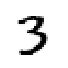

In [ ]:
show_image(three_tensors[1]);

对于每个像素位置，我们想要计算该像素强度的所有图像的平均值。为此，我们首先将此列表中的所有图像组合成一个三维张量。描述这种张量最常见的方式是将其称为*秩-3张量*。我们经常需要将集合中的单个张量堆叠成一个单独的张量。不出所料，PyTorch 提供了一个名为 `stack` 的函数，我们可以用它来实现这个目的。

PyTorch 中的一些操作，例如取平均值，要求我们将整数类型转换为浮点类型。由于我们稍后会需要这个，我们现在也将我们的堆叠张量转换为 `float`。在 PyTorch 中进行转换就像输入要转换为的类型名称一样简单，并将其视为一个方法。

通常，当图像是浮点数时，像素值被期望在 0 和 1 之间，因此我们也将在此处除以 255：

In [ ]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

张量最重要的属性之一可能是其*形状*。这告诉你每个轴的长度。在这种情况下，我们可以看到我们有 6,131 张图像，每张图像大小为 28×28 像素。这个张量没有特定的属性表明第一个轴是图像的数量，第二个是高度，第三个是宽度 - 张量的语义完全取决于我们以及我们如何构造它。就 PyTorch 而言，它只是内存中的一堆数字。

张量形状的*长度*就是它的秩：

In [ ]:
len(stacked_threes.shape)

3

对于你来说，牢记和练习张量术语的这些部分真的非常重要：_秩_是张量中轴或维度的数量；_形状_是张量的每个轴的大小。

> 注意，因为术语“维度”有时以两种方式使用。考虑到我们生活在“三维空间”中，物理位置可以用 3-向量 `v` 描述。但是根据 PyTorch，属性 `v.ndim`（看起来像是 `v` 的“维度数量”）等于一，而不是三！为什么？因为 `v` 是一个向量，它是一个秩为一的张量，意味着它只有一个_轴_（即使该轴的长度为三）。换句话说，有时“维度”用于表示轴的大小（“空间是三维的”）；其他时候，它用于表示秩，或轴的数量（“矩阵有两个维度”）。当感到困惑时，将所有语句转换为秩、轴和长度这些明确的术语，我觉得这很有帮助。

我们也可以直接使用 `ndim` 获取张量的秩：

In [ ]:
stacked_threes.ndim

3

最后，我们可以计算理想的数字3是什么样子的。我们通过沿着我们堆叠的三维张量的维度0取平均值来计算所有图像张量的平均值。这个维度用来索引所有的图像。

换句话说，对于每个像素位置，这将计算所有图像上该像素的平均值。结果将是每个像素位置一个值，或者说是一张图像。下面是它的代码：

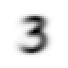

In [ ]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

根据这个数据集，这就是理想的数字3！（你可能不喜欢，但这就是最佳数字3的表现！）你可以看到，所有图像认为应该是暗的地方都非常暗，但是在图像不一致的地方会变得雾状和模糊。

让我们对数字7做同样的事情，但一次性把所有步骤放在一起，以节省一些时间：

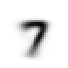

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

现在让我们选择一个任意的数字3，并测量它与我们的“理想数字”的*距离*。

> 停下来思考一下：你将如何计算特定图像与我们的理想数字的相似程度？在继续之前，记得离开这本书，记录下一些想法！研究表明，当你通过解决问题、实验和尝试新想法来参与学习过程时，回忆和理解会显著提高。

这是一个样本数字3：

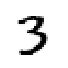

In [ ]:
a_3 = stacked_threes[1]
show_image(a_3);

我们如何确定图像与我们理想的3之间的距离？我们不能简单地将图像的像素与理想数字的像素之间的差异相加。一些差异将是正值，而另一些将是负值，这些差异将相互抵消，导致一个图像在某些地方太暗而在其他地方太亮可能被显示为与理想值的总差异为零。这将是误导性的！

为了避免这种情况，在这种情况下，数据科学家测量距离的两种主要方法：

- 求差的*绝对值*的平均值（绝对值是一种将负值替换为正值的函数）。这被称为*平均绝对差*或*L1范数*。
- 求差的*平方*的平均值，然后取*平方根*（这是撤消平方的操作）。这称为*均方根误差*（RMSE）或*L2范数*。

> 重要提示：忘记数学也没关系：在这本书中，我们通常假设你已完成了高中数学，并记得至少一些内容...... 但每个人都会忘记一些东西！这取决于你在此期间有没有理由去实践的内容。也许你已经忘记了什么是_平方根_，或者它们确切地如何工作。没问题！每当你遇到本书中未完全解释的数学概念时，不要只是继续前进；相反，停下来查找一下。确保你理解基本概念，它是如何工作的以及为什么我们可能会使用它。刷新你理解的最佳方法之一是 Khan Academy。例如，Khan Academy有一个很棒的[平方根介绍](https://www.khanacademy.org/math/algebra/x2f8bb11595b61c86:rational-exponents-radicals/x2f8bb11595b61c86:radicals/v/understanding-square-roots)。

现在让我们尝试这两种方法：

In [ ]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [ ]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

在这两种情况下，我们的3与“理想”的3之间的距离都小于与理想7之间的距离。因此，我们的简单模型在这种情况下会给出正确的预测。

PyTorch已经提供了这两种作为*损失函数*。你会在`torch.nn.functional`中找到它们，PyTorch团队建议将其导入为`F`（在fastai中默认以这个名称可用）: 

In [ ]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

这里`mse`代表*均方误差*，而`l1`是指标准数学术语中的*绝对值平均值*（在数学中称为*L1范数*）。

> S：直观地说，L1范数和均方误差（MSE）之间的区别在于，后者会比前者更严重地惩罚较大的错误（对较小的错误更宽容）。

> J: 当我第一次遇到这个“L1”东西时，我查了一下它到底是什么意思。我在谷歌上发现它是使用绝对值的矢量范数，于是我查了“矢量范数”，开始阅读：_给定一个域F上的向量空间V，V上的范数是一个非负值的任意函数p: V → \[0,+∞)，满足以下性质：对于所有a ∈ F 和所有u, v ∈ V, p(u + v) ≤ p(u) + p(v)..._ 然后我就停止阅读了。“呃，我永远都无法理解数学！”我想，这已经是第一千次了。从那以后，我了解到每次在实践中遇到这些复杂的数学术语时，我都可以用一点点代码来替代它们！比如，_L1损失_ 就等于 `(a-b).abs().mean()`，其中 `a` 和 `b` 是张量。我猜数学专家只是和我想得不一样… 在这本书中，我会确保每次遇到一些数学术语时，我都会给你它所对应的一小段代码，并用通俗的语言解释发生了什么。

我们刚刚在 PyTorch 张量上完成了各种数学操作。如果你以前在 NumPy 中做过一些数值编程，你可能会注意到它们与 NumPy 数组相似。让我们来看看这两种非常重要的数据结构。

### NumPy 数组和 PyTorch 张量

[NumPy](https://numpy.org/) 是 Python 中用于科学和数值编程的最广泛使用的库。它提供了与 PyTorch 非常相似的功能和 API，但不支持使用 GPU 或计算梯度，这两个功能对深度学习非常重要。因此，在本书中，我们通常会尽可能使用 PyTorch 张量而不是 NumPy 数组。

（请注意，fastai 在 NumPy 和 PyTorch 中添加了一些功能，使它们彼此更加相似。如果本书中的任何代码在你的计算机上无法运行，则有可能是你忘记在笔记本的开头包含这样一行代码：`from fastai.vision.all import *`。）

但是数组和张量是什么，你为什么要关心它们呢？

Python 相对于许多其他编程语言而言速度较慢。在 Python、NumPy 或 PyTorch 中的任何快速操作都很可能是对另一种语言（特别是 C 语言）编写（并优化）的编译对象的包装器。事实上，**NumPy 数组和 PyTorch 张量可以比纯 Python 完成计算快数千倍。**

NumPy 数组是一个多维数据表，其中所有项目都是相同类型的。由于类型可以是任何类型，它们甚至可以是数组的数组，其中最内部的数组可能具有不同的大小——这称为“不规则数组”。通过“多维数据表”，我们指的是，例如列表（一维）、表或矩阵（二维）、“表格的表格”或“立方体”（三维）等。如果所有项目都是简单类型，例如整数或浮点数，则 NumPy 将它们存储为内存中的紧凑 C 数据结构。这就是 NumPy 的优势所在。NumPy 具有各种各样的运算符和方法，可以在这些紧凑结构上以优化的 C 速度运行计算，因为它们是用优化的 C 编写的。

PyTorch 张量与 NumPy 数组几乎相同，但有一个额外的限制，解锁了一些额外的功能。它们相同之处在于，它们也是多维数据表，其中所有项目都是相同类型的。但是，限制在于张量不能使用任意旧类型，它必须对所有组件使用单个基本数值类型。例如，PyTorch 张量不能是不规则的。它始终是一个具有规则形状的多维矩形结构。

NumPy 在这些结构上支持的绝大多数方法和运算符也受到 PyTorch 的支持，但 PyTorch 张量具有其他功能。一个主要的功能是这些结构可以存在于 GPU 上，这样它们的计算将针对 GPU 进行优化，并且可以更快地运行（给定大量的值进行处理）。此外，PyTorch 可以自动计算这些操作的导数，包括操作的组合。正如你将看到的，如果没有这种能力，实际上无法进行深度学习。

> 如果你不知道 C 是什么，也不要担心，因为你根本不需要它。简而言之，C 是一种低级语言（低级意味着更类似于计算机内部使用的语言），与 Python 相比速度非常快。为了利用其速度，在 Python 编程时，尽量避免编写循环，而是将它们替换为直接作用于数组或张量的命令。

对于 Python 程序员来说，学习如何有效地使用数组/张量 API 可能是最重要的新编码技能之一。我们将在本书的后面展示更多技巧，但现在这是你需要了解的关键内容的摘要。

要创建数组或张量，请将列表（或列表的列表，或列表的列表的列表等）传递给 `array()` 或 `tensor()`：

In [ ]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [ ]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

所有后续的操作都是在张量上展示的，但是 NumPy 数组的语法和结果是相同的。

你可以选择一行（注意，与 Python 中的列表一样，张量是从 0 开始索引的，因此 1 指的是第二行/列）：

In [ ]:
tns[1]

tensor([4, 5, 6])

或者通过使用 `:` 来指示*第一个轴的所有元素*来选择一列（我们有时将张量/数组的维度称为*轴*）：

In [ ]:
tns[:,1]

tensor([2, 5])

你可以将这些与 Python 切片语法结合起来（`[start:end]`，其中 `end` 被排除），以选择行或列的一部分：

In [ ]:
tns[1,1:3]

tensor([5, 6])

你可以使用标准运算符，如 `+`、`-`、`*`、`/`：

In [ ]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

张量具有类型：

In [ ]:
tns.type()

'torch.LongTensor'

并且会根据需要自动更改类型，例如从 `int` 更改为 `float`：

In [ ]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

那么，我们的基准模型好吗？要量化这一点，我们必须定义一个度量标准。

## 使用广播计算指标

请记住，度量标准是根据我们模型的预测和数据集中的正确标签计算出来的一个数字，以告诉我们我们的模型有多好。例如，我们可以使用前面部分看到的均方误差或均绝对误差中的任何一个函数，并在整个数据集上对它们取平均值。然而，这两个都不是大多数人能够理解的数字；在实践中，我们通常将*准确率*作为分类模型的度量标准。

正如我们之前讨论过的，我们想在*验证集*上计算我们的度量标准。这样做是为了避免无意中过拟合——即，训练一个模型只在我们的训练数据上表现良好。对于我们这里作为第一次尝试使用的像素相似度模型而言，这实际上并不是一个风险，因为它没有训练组件，但我们仍然会使用一个验证集来遵循正常的做法，并为稍后的第二次尝试做好准备。

为了获得一个验证集，我们需要从训练数据中完全删除一些数据，这样模型就完全看不到这些数据。事实证明，MNIST数据集的创建者已经为我们做了这个工作。你还记得有一个名为*valid*的完整目录吗？这个目录就是用来做这个的！

所以首先，让我们为来自该目录的我们的3和7创建张量。这些是我们将用来计算第一次尝试模型质量的度量标准的张量，它度量与理想图像之间的距离：

In [ ]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

养成在进行操作时检查形状的习惯是很好的。在这里，我们看到两个张量，一个代表大小为28×28的1,010个图像的3验证集，另一个代表大小为28×28的1,028个图像的7验证集。

我们最终想要编写一个函数 `is_3`，它将决定任意图像是3还是7。它将通过决定这个任意图像更接近我们的两个"理想数字"中的哪一个来实现这一点。为此，我们需要定义一种距离的概念——即，一个计算两个图像之间距离的函数。

我们可以编写一个简单的函数，使用与我们在上一节中编写的非常相似的表达式来计算平均绝对误差：

In [ ]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

这与我们之前计算的相同值，即理想数字3 `mean3` 与任意示例3 `a_3` 之间的距离相同，它们都是形状为 `[28,28]` 的单张图像张量。

但是，为了计算整体准确性的度量标准，我们需要计算每个图像在验证集中与理想数字3的距离。我们如何进行这个计算呢？我们可以编写一个循环，遍历所有堆叠在我们的验证集张量 `valid_3_tens` 中的单张图像张量，它的形状为 `[1010,28,28]`，代表了1,010个图像。但是有一个更好的方法。

当我们使用相同的距离函数来比较两个单个图像时，但将表示3验证集的张量 `valid_3_tens` 作为参数传递时，会发生非常有趣的事情：

In [ ]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1050, 0.1526, 0.1186,  ..., 0.1122, 0.1170, 0.1086]),
 torch.Size([1010]))

与其抱怨形状不匹配，而是返回了每个图像的距离作为一个长度为1,010的向量（即一个秩为1的张量），该向量包含了验证集中的所有3。这是如何发生的？

再回顾一下我们的函数 `mnist_distance`，你会发现我们在这里有一个减法 `(a-b)`。这个神奇的技巧在于，当PyTorch尝试对不同秩的两个张量执行简单的减法操作时，它会使用 *广播*。也就是说，它会自动将秩较小的张量扩展为与秩较大的张量相同的大小。广播是一个重要的功能，使得张量代码更容易编写。

在广播之后，使得两个参数张量具有相同的秩后，PyTorch会将其应用于相同秩的两个张量的每个相应元素，并返回张量结果。例如：

In [ ]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

在这种情况下，PyTorch将 `mean3`，一个表示单个图像的秩为2的张量，视为是1,010个相同图像的副本，然后从验证集中的每个3中减去每个副本。你会期望这个张量有什么形状？在查看下面的答案之前，试着自己想出来：

In [ ]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

我们正在计算我们的“理想3”与验证集中的每个1,010个3之间的差异，对于每个28×28图像，结果是形状 `[1010,28,28]`。

有几个关于广播实现的重要要点，这使得它不仅对于表达性而言很有价值，而且对于性能也很重要：

- PyTorch 实际上并没有复制 `mean3` 1,010 次。它 *假装* 它是一个具有该形状的张量，但实际上并没有分配任何额外的内存
- 它在 C 中完成整个计算（或者，如果你使用的是 GPU，则在 CUDA 中完成，在 GPU 上等效于 C），比纯 Python 快数万倍（在 GPU 上可能快数百万倍！）

这对于所有在 PyTorch 中执行的广播和逐元素操作和函数都是正确的。*这是你需要了解的最重要的技术，可以创建高效的 PyTorch 代码。*

接下来，在 `mnist_distance` 中，我们看到 `abs`。当应用于张量时，你可能能猜到这个操作的作用。它将方法应用于张量中的每个单独元素，并返回结果的张量（即它逐元素地应用该方法）。因此，在这种情况下，我们将获得 1,010 个绝对值矩阵。

最后，我们的函数调用了 `mean((-1,-2))`。元组 `(-1,-2)` 表示轴的范围。在 Python 中，`-1` 指的是最后一个元素，`-2` 指的是倒数第二个元素。因此，在这种情况下，这告诉 PyTorch 我们要计算沿着张量的最后两个轴索引的值的平均值。最后两个轴是图像的水平和垂直维度。在沿着最后两个轴取平均值之后，我们只剩下第一个张量轴，它索引了我们的图像，这就是为什么我们最终的大小是 `(1010)`。换句话说，对于每个图像，我们计算了该图像中所有像素的强度的平均值。

我们将在本书中学到更多有关广播的知识，特别是在 <<chapter_foundations>> 中，我们也会经常练习它。

我们可以使用 `mnist_distance` 来确定一个图像是否是3，使用以下逻辑：如果待定数字与理想的3之间的距离小于与理想的7之间的距离，则它是一个3。这个函数将自动执行广播，并像所有 PyTorch 函数和运算符一样逐元素应用：

In [ ]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

让我们在示例案例中测试一下：

In [ ]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

注意，当我们将布尔响应转换为浮点数时，对于 `True` 我们得到 `1.0`，对于 `False` 我们得到 `0.0`。由于广播的存在，我们也可以在完整的 3 的验证集上进行测试：

In [ ]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

现在，我们可以通过对所有 3 的函数值取平均值以及对所有 7 的函数值取平均值的倒数来计算每个 3 和 7 的准确率：

In [ ]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

这看起来是一个相当不错的开端！我们在 3 和 7 上都获得了超过 90% 的准确率，并且我们已经学会了如何使用广播方便地定义度量。

但让我们实话实说：3 和 7 是非常不同的数字。到目前为止，我们只对 10 个可能的数字中的 2 个进行了分类。因此，我们需要做得更好！

为了做得更好，也许现在是时候尝试一个真正学习的系统了，即可以自动修改自身以提高性能的系统。换句话说，是时候谈谈训练过程和随机梯度下降（SGD）了。

## 随机梯度下降 (SGD)

你还记得我们在<<chapter_intro>>引用的Arthur Samuel描述机器学习的方式吗？

> :假设我们安排了某种自动测试任何当前权重分配的有效性的手段，并提供一种机制来改变权重分配，以便最大化性能。我们不需要详细讨论这样一个过程，就能看出它完全可以自动化，并且能够让一个这样编程的机器从经验中“学习”。

正如我们讨论的那样，这是让我们拥有一个可以变得越来越好的模型的关键，即可以学习的模型。但是我们的像素相似度方法并没有真正做到这一点。我们没有任何一种权重分配，也没有任何一种根据测试权重分配的有效性来改进的方式。换句话说，我们不能通过修改一组参数来改进我们的像素相似度方法。为了充分利用深度学习的威力，我们首先必须将我们的任务表示为Arthur Samuel所描述的方式。

我们可以尝试寻找每个单独像素的相似度，为每个像素提供一组权重，使得与特定类别最有可能是黑色的像素相关联的权重最高。例如，对于 7，右下角的像素不太可能被激活，因此它们对于 7 应该有较低的权重，但是它们很可能被 8 激活，因此它们对于 8 应该有较高的权重。这可以表示为每个可能类别的函数和一组权重值，例如数字 8 的概率：

```
def pr_eight(x,w): return (x*w).sum()
```

在这里，我们假设 `x` 是表示为向量的图像，换句话说，所有的行都被堆叠在一起形成一条长长的线。我们还假设权重是一个向量 `w`。如果我们有了这个函数，那么我们只需要一种方法来更新权重，使它们变得更好一些。使用这种方法，我们可以重复这一步骤多次，使权重变得越来越好，直到它们达到我们能做到的最好状态。

我们想要找到向量 `w` 的具体值，使得我们的函数对于那些实际上是 8 的图像结果较高，而对于那些不是的图像结果较低。搜索最佳向量 `w` 是搜索最佳函数来识别 8 的一种方法。（因为我们还没有使用深度神经网络，我们受限于我们的函数实际能够做什么——我们将在本章后面解决这个约束。）

具体来说，以下是我们需要的步骤，将这个函数转化为一个机器学习分类器：

1. *初始化* 权重。
1. 对于每个图像，使用这些权重来*预测*它是 3 还是 7。
1. 基于这些预测，计算模型的好坏（其*损失*）。
1. 计算*梯度*，衡量每个权重的变化如何改变损失。
1. 根据该计算*步进*（即更改）所有权重。
1. 返回步骤 2，并*重复*该过程。
1. 迭代直到决定*停止*训练过程（例如，因为模型已足够好或你不想再等待了）。

这七个步骤，如 <<gradient_descent>> 所示，是训练所有深度学习模型的关键。深度学习完全依赖于这些步骤，这一点非常令人惊讶和反直觉。令人惊奇的是，这个过程可以解决如此复杂的问题。但正如你将看到的，它确实可以做到！

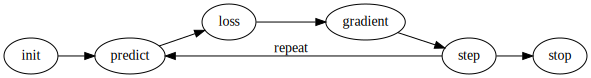

In [ ]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

有许多不同的方法来执行这七个步骤，我们将在本书的其余部分学习到它们。这些是深度学习实践者的关键细节，但事实证明，每个步骤的一般方法通常遵循一些基本原则。以下是一些指导原则：

- 初始化：我们将参数初始化为随机值。这可能听起来令人惊讶。当然，我们还有其他选择，比如将它们初始化为对于该类别激活该像素的次数的百分比——但由于我们已经知道我们有一种改进这些权重的方法，事实证明只是从随机权重开始就可以很好地工作。
- 损失：这就是塞缪尔所说的*根据实际表现测试当前权重分配效果*时所指的。我们需要一个函数，它返回一个数字，如果模型的性能好，这个数字就很小（标准做法是将小损失视为好的，而大损失视为坏的，尽管这只是一种约定）。
- 步骤：确定权重是否应该增加一点或减少一点的简单方法是：尝试一下。通过增加一小部分权重，然后观察损失是上升还是下降。一旦找到正确的方向，然后可以多试一点和少试一点，直到找到一个效果良好的量。然而，这样做很慢！正如我们将看到的，微积分的魔力使我们能够直接计算出每个权重应该改变的方向和大致量，而不必尝试所有这些小变化。这就是计算*梯度*的方法。这只是一种性能优化，我们可以通过使用较慢的手动过程获得完全相同的结果。
- 停止：一旦我们决定要为模型训练多少个周期（前面的列表中提供了一些建议），我们就应用该决定。这是应用该决定的地方。对于我们的数字分类器，我们会持续训练，直到模型的准确率开始变差，或者我们用完了时间。

在将这些步骤应用于我们的图像分类问题之前，让我们先在一个更简单的情况下说明它们是什么样子。首先，我们将定义一个非常简单的函数，二次函数——假设这是我们的损失函数，而`x`是函数的权重参数：

In [ ]:
def f(x): return x**2

这是该函数的图表：

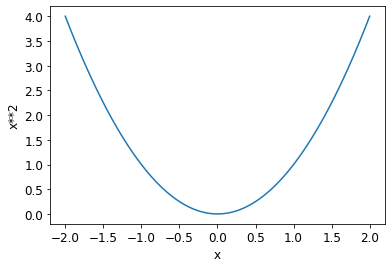

In [ ]:
plot_function(f, 'x', 'x**2')

我们之前描述的步骤序列从选择参数的随机值开始，然后计算损失的值：

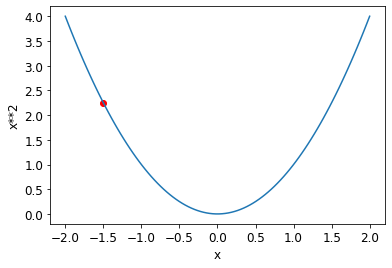

In [ ]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

现在我们看看如果我们稍微增加或减少参数会发生什么——*调整*。这只是特定点的斜率：

<img alt="A graph showing the squared function with the slope at one point" width="400" src="images/grad_illustration.svg"/>

我们可以在斜率的方向上稍微调整我们的权重，再次计算损失和调整，然后重复这个过程几次。最终，我们将到达曲线的最低点：

<img alt="An illustration of gradient descent" width="400" src="images/chapter2_perfect.svg"/>

这个基本思想一直延续到了艾萨克·牛顿，他指出我们可以用这种方法优化任意函数。无论我们的函数变得多么复杂，梯度下降的这种基本方法都不会发生显著变化。在本书的后面，我们将看到的唯一小的变化是一些方便的方法，可以让它变得更快，找到更好的步骤。

### 计算梯度

这个神奇的步骤是我们计算梯度的部分。正如我们提到的，我们使用微积分作为性能优化；它让我们能够更快地计算出当我们调整参数时损失会增加还是减少。换句话说，梯度会告诉我们我们需要改变每个权重多少才能使我们的模型变得更好。

你可能还记得高中微积分课上学到的一个概念：函数的*导数*告诉你它的参数变化会如何改变它的结果。如果不记得了，没关系，我们在高中毕业后很多人都会忘记微积分！但是在继续之前，你必须对导数有一些直观的理解，所以如果你对这个概念感到很模糊，可以前往 Khan Academy 完成[关于基本导数的课程](https://www.khanacademy.org/math/differential-calculus/dc-diff-intro)。你不必知道如何计算导数，你只需要知道导数是什么。

关于导数的关键一点是：对于任何函数，比如我们在前一节看到的二次函数，我们都可以计算它的导数。导数是另一个函数。它计算的是变化，而不是值。例如，在值为 3 处的二次函数的导数告诉我们函数在值为 3 处的变化速度。更具体地说，你可能还记得梯度被定义为*上升/下降*，也就是函数值的变化量除以参数值的变化量。当我们知道我们的函数会如何变化时，我们就知道了要使其变小需要做些什么。这就是机器学习的关键：有一种方法来改变函数的参数使其变小。微积分为我们提供了一个计算的捷径，即导数，它让我们能够直接计算函数的梯度。

有一件重要的事情需要注意，那就是我们的函数有很多需要调整的权重，所以当我们计算导数时，我们不会得到一个数字，而是很多个——每个权重都对应一个梯度。但在这里没有什么数学上的技巧；你可以计算关于一个权重的导数，并将所有其他权重视为常数，然后依次对每个其他权重重复这个过程。这就是如何计算所有的梯度的，对于每一个权重。

我们刚才提到你不必自己计算任何梯度。这是怎么回事呢？令人惊讶的是，PyTorch 能够自动计算几乎任何函数的导数！而且它计算得非常快。大多数情况下，它至少和你手动创建的任何导数函数一样快。让我们看一个例子。

首先，让我们选择一个我们希望计算梯度的张量值：

In [ ]:
xt = tensor(3.).requires_grad_()

注意到特殊的方法 `requires_grad_` 了吗？这是我们用来告诉 PyTorch，我们希望在该值上计算梯度的神奇咒语。它本质上是给变量打上标记，因此 PyTorch 将记住如何计算你要求的其他直接计算的梯度。

> a: 如果你来自数学或物理学领域，这个 API 可能会让你感到困惑。在这些上下文中，函数的 "梯度" 只是另一个函数（即它的导数），因此你可能期望与梯度相关的 API 会给你一个新的函数。但在深度学习中，“梯度”通常意味着函数在特定参数值处的导数值。PyTorch API 也将重点放在参数上，而不是你实际计算梯度的函数。一开始可能感觉有些反直觉，但这只是一种不同的视角。

现在我们用那个值来计算我们的函数。请注意 PyTorch 打印的不仅是计算出的值，还有一条注释，说明它有一个梯度函数，将在需要时用于计算我们的梯度：

In [ ]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

最后，我们告诉 PyTorch 为我们计算梯度：

In [ ]:
yt.backward()

"backward" 这里指的是 *反向传播*，这是计算每一层导数的过程的名称。在第 <<chapter_foundations>> 章中，我们将看到如何从头开始计算深度神经网络的梯度。这被称为网络的 "反向传播"，与 "前向传播" 相对应，前向传播是计算激活的过程。如果 `backward` 只是被称为 `calculate_grad`，生活可能会更容易，但是深度学习的人确实喜欢在可能的地方添加术语！

我们现在可以通过检查张量的 grad 属性来查看梯度：

In [ ]:
xt.grad

tensor(6.)

如果你记得你高中的微积分规则，那么 `x**2` 的导数是 `2*x`，而我们有 `x=3`，所以梯度应该是 `2*3=6`，这正是 PyTorch 为我们计算的结果！

现在我们将重复之前的步骤，但使用函数的向量参数：

In [ ]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

我们将在函数中添加 `sum`，以便它可以接受一个向量（即，秩为 1 的张量），并返回一个标量（即，秩为 0 的张量）：

In [ ]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

我们的梯度是 `2*xt`，正如我们预期的那样！

In [ ]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

梯度只告诉我们函数的斜率，它们并没有准确告诉我们应该调整参数多少。但它们给了我们一些思路；如果斜率非常大，那么可能意味着我们需要做更多的调整，而如果斜率非常小，则可能意味着我们接近最优值了。

### 以学习率逐步推进

决定基于梯度值如何改变我们的参数是深度学习过程中的一个重要部分。几乎所有方法都始于将梯度乘以一个小数，称为*学习率*（LR）。学习率通常是介于0.001和0.1之间的数字，尽管它可以是任何值。通常，人们通过尝试几个学习率，并在训练后找到哪一个产生最佳模型来选择学习率（我们将在本书的后面展示一个更好的方法，称为*学习率查找器*）。选择了学习率后，你可以使用这个简单的函数来调整参数：

```
w -= gradient(w) * lr
```

这被称为*使用优化器步骤*对参数进行*步进*。注意我们从参数中减去了`gradient * lr`来更新它。这使我们能够根据斜率的方向调整参数，即当斜率为负时增加参数，当斜率为正时减少参数。我们希望根据斜率的方向调整参数，因为我们在深度学习中的目标是*最小化*损失。

如果选择的学习率太低，可能意味着需要执行很多步骤。 <<descent_small>> 给出了示例。

<img alt="An illustration of gradient descent with a LR too low" width="400" caption="Gradient descent with low LR" src="images/chapter2_small.svg" id="descent_small"/>

但是选择一个太高的学习率甚至更糟糕——它实际上可能导致损失变得*更糟*，就像我们在<<descent_div>>中看到的那样！

<img alt="An illustration of gradient descent with a LR too high" width="400" caption="Gradient descent with high LR" src="images/chapter2_div.svg" id="descent_div"/>

如果学习率太高，它也可能会“弹跳”，而不是真正地发散；<<descent_bouncy>>显示了这样做成功训练需要很多步骤。

<img alt="An illustation of gradient descent with a bouncy LR" width="400" caption="Gradient descent with bouncy LR" src="images/chapter2_bouncy.svg" id="descent_bouncy"/>

现在让我们在一个端到端的示例中应用所有这些。

### 端到端 SGD 示例

我们已经了解了如何使用梯度来寻找最小值。现在是时候看一个 SGD 示例，并了解如何利用找到的最小值来训练模型以更好地拟合数据。

让我们从一个简单的合成示例模型开始。想象一下，你正在测量过山车在顶峰上方的速度。它会从开始时速度很快，然后在上坡时减慢；在顶峰上最慢，然后在下坡时又会加速。你想建立一个关于速度随时间变化的模型。如果你每秒手动测量速度20秒，结果可能如下所示：

In [ ]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

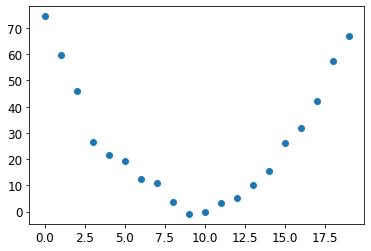

In [ ]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

我们已经加入了一些随机噪声，因为手动测量并不精确。这意味着很难回答问题：过山车的速度是多少？使用 SGD，我们可以尝试找到一个与我们的观察结果匹配的函数。我们无法考虑每个可能的函数，所以让我们假设它是二次的；即，一个形式为 `a*(time**2)+(b*time)+c` 的函数。

我们希望清楚地区分函数的输入（我们测量过山车速度的时间）和其参数（定义我们试图拟合的二次函数的值）。因此，让我们将参数收集在一个参数中，从而在函数的签名中分离输入 `t` 和参数 `params`：

In [ ]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

换句话说，我们将寻找最适合数据的最佳函数的问题，限制为寻找最佳的*二次*函数。这大大简化了问题，因为每个二次函数都由三个参数 `a`、`b` 和 `c` 完全定义。因此，要找到最佳的二次函数，我们只需要找到 `a`、`b` 和 `c` 的最佳值。

如果我们可以解决二次函数的三个参数的问题，我们就可以将相同的方法应用于具有更多参数的其他更复杂的函数，例如神经网络。让我们首先找到 `f` 的参数，然后我们将回来，对 MNIST 数据集使用神经网络做同样的事情。

首先，我们需要定义“最佳”的含义。我们通过选择一个*损失函数*来精确地定义这一点，该函数将基于预测和目标返回一个值，其中函数的较低值对应于“更好”的预测。对于连续数据，常用的损失函数是*均方误差*：

In [ ]:
def mse(preds, targets): return ((preds-targets)**2).mean()

现在，让我们按照我们的七个步骤来进行工作。

#### 步骤一：初始化参数

首先，我们将参数初始化为随机值，并告诉 PyTorch 我们希望跟踪它们的梯度，使用 `requires_grad_`：

In [ ]:
params = torch.randn(3).requires_grad_()

In [ ]:
#hide
orig_params = params.clone()

#### 步骤 2：计算预测值

接下来，我们计算预测值：

In [ ]:
preds = f(time, params)

让我们创建一个小函数来查看我们的预测与目标的接近程度，并进行查看：

In [ ]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

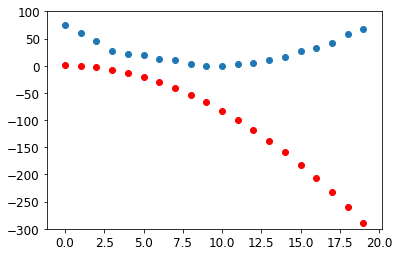

In [ ]:
show_preds(preds)

这看起来并不接近——我们随机的参数表明过山车最终会倒车，因为我们有负速度！

#### 步骤 3：计算损失


我们计算损失如下：

In [ ]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

我们的目标是现在改进这个。为了做到这一点，我们需要知道梯度。

#### 步骤 4：计算梯度

下一步是计算梯度。换句话说，计算参数需要如何改变的近似值：

In [ ]:
loss.backward()
params.grad

tensor([-53195.8594,  -3419.7146,   -253.8908])

In [ ]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

我们可以利用这些梯度来改进我们的参数。我们需要选择一个学习率（关于如何在实践中选择学习率，我们将在下一章中讨论；现在我们将使用 1e-5，即 0.00001）:

In [ ]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

#### 步骤 5：更新权重。

现在我们需要根据刚刚计算的梯度更新参数：

In [ ]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

> 注意理解这一部分取决于记住最近的历史。要计算梯度，我们在 `loss` 上调用 `backward`。但是这个 `loss` 本身是通过 `mse` 计算的，而 `mse` 又以 `preds` 作为输入，`preds` 是使用 `f` 计算的，`f` 又以 `params` 作为输入，而 `params` 是我们最初调用 `requires_grad_` 的对象——这是最初的调用，现在允许我们在 `loss` 上调用 `backward`。这一系列函数调用代表了函数的数学组合，这使得 PyTorch 能够在幕后使用微积分的链式法则来计算这些梯度。

让我们看看损失是否有所改善：

In [ ]:
preds = f(time,params)
mse(preds, speed)

tensor(5435.5366, grad_fn=<MeanBackward0>)

并查看图表：

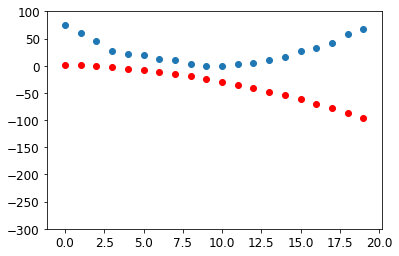

In [ ]:
show_preds(preds)

我们需要重复这个过程几次，所以我们将创建一个函数来执行一步操作：

In [ ]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### 步骤 6: 重复这个过程

现在我们迭代。通过循环和执行许多改进，我们希望达到一个好的结果：

In [ ]:
for i in range(10): apply_step(params)

5435.53662109375
1577.4495849609375
847.3780517578125
709.22265625
683.0757446289062
678.12451171875
677.1839599609375
677.0025024414062
676.96435546875
676.9537353515625


In [ ]:
#hide
params = orig_params.detach().requires_grad_()

损失正在下降，正如我们所希望的那样！但仅查看这些损失数字掩盖了一个事实，即每次迭代代表着尝试完全不同的二次函数，以找到最佳的可能二次函数。如果我们不是打印出损失函数，而是在每个步骤中绘制函数，我们就可以看到形状是如何接近我们数据的最佳可能二次函数的：

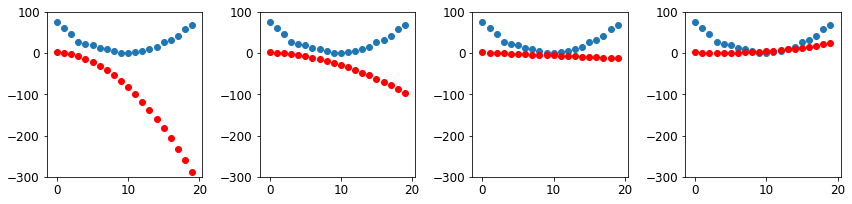

In [ ]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### 第 7 步：停止

我们刚刚任意地决定在 10 个 epochs 后停止。在实践中，我们会观察训练和验证损失以及我们的指标，以决定何时停止，正如我们所讨论的那样。

### 总结梯度下降

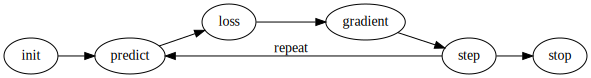

In [ ]:
#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

总结一下，在开始时，我们模型的权重可以是随机的（从头开始训练）或来自预训练模型（迁移学习）。在第一种情况下，模型的输出与我们期望的结果没有任何关系，即使在第二种情况下，预训练模型很可能在我们所针对的特定任务上表现不佳。因此，模型需要学习更好的权重。

我们首先使用一个损失函数比较模型给出的输出与我们的目标（我们有标记的数据，所以我们知道模型应该给出什么结果），损失函数返回一个数字，我们希望通过改进我们的权重使其尽可能低。为此，我们从训练集中取出一些数据项（如图像）并将它们提供给我们的模型。我们使用损失函数比较相应的目标，得到的分数告诉我们我们的预测有多么错误。然后，我们稍微改变权重使其稍微变得更好。

为了找到如何改变权重使损失稍微变好，我们使用微积分来计算梯度。（实际上，我们让 PyTorch 为我们完成！）让我们考虑一个类比。想象一下，你在山上迷路了，你的车停在最低点。为了找到回到车辆的路，你可能会朝一个随机方向走，但那可能帮不了太多。由于你知道你的车在最低点，最好是沿着山下走。通过始终朝着最陡的下坡方向迈出一步，你最终应该能够到达目的地。我们使用梯度的大小（即坡度的陡峭程度）来告诉我们应该迈多大的一步；具体来说，我们将梯度乘以我们选择的一个称为学习率的数字来决定步长。然后，我们*迭代*直到达到最低点，那就是我们的停车场，然后我们可以*停止*。

我们刚刚看到的所有内容都可以直接转移到 MNIST 数据集上，除了损失函数。现在让我们看看如何定义一个良好的训练目标。

## MNIST 损失函数

我们已经有了我们的自变量 `x` ——这些是图像本身。我们将它们都连接成一个单独的张量，同时将它们从矩阵的列表（一个秩为 3 的张量）变为向量的列表（一个秩为 2 的张量）。我们可以使用 `view` 来实现这一点，`view` 是 PyTorch 的一个方法，它可以改变张量的形状而不改变其内容。`-1` 是 `view` 的一个特殊参数，意思是“使这个轴尽可能大以适应所有的数据”： 

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

我们需要为每个图像标签。我们将使用 `1` 表示数字 3，`0` 表示数字 7：

In [ ]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

在 PyTorch 中，`Dataset` 在索引时需要返回一个元组 `(x,y)`。Python 提供了 `zip` 函数，结合 `list`，可以简单地实现这个功能：

In [ ]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

现在我们需要为每个像素分配一个（初始随机的）权重（这是我们七步过程中的 *初始化* 步骤）：

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

函数 `weights*pixels` 不够灵活 —— 当像素等于 0 时，它总是等于 0（即，其 *截距* 为 0）。你可能还记得高中数学中的线性方程 `y=w*x+b`；我们仍然需要 `b`。我们也将它初始化为一个随机数：

In [ ]:
bias = init_params(1)

In neural networks, the `w` in the equation `y=w*x+b` is called the *weights*, and the `b` is called the *bias*. Together, the weights and bias make up the *parameters*.

> 术语：参数（Parameters）：模型的权重和偏置。权重是方程 `w*x+b` 中的 `w`，而偏置是该方程中的 `b`。

现在我们可以计算一张图像的预测：

In [ ]:
(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

虽然我们可以使用 Python 的 `for` 循环来计算每个图像的预测，但那会非常慢。由于 Python 循环不在 GPU 上运行，并且因为 Python 在一般情况下循环速度较慢，我们需要尽可能多地使用高级函数来表示模型中的计算。

在这种情况下，有一个非常方便的数学运算可以为矩阵的每一行计算 `w*x`，它称为*矩阵乘法*。 <<matmul>> 展示了矩阵乘法的形式。

<img alt="Matrix multiplication" width="400" caption="Matrix multiplication" src="images/matmul2.svg" id="matmul"/>

这张图片展示了两个矩阵 `A` 和 `B` 相乘的过程。结果矩阵，我们称之为 `AB`，中的每个元素包含了对应行的 `A` 中的每个元素与对应列的 `B` 中的每个元素相乘，并相加起来。例如，第 1 行第 2 列（黄色带红色边框的点）的计算公式为 $a_{1,1} * b_{1,2} + a_{1,2} * b_{2,2}$。如果你需要复习矩阵乘法，请查看 *Khan Academy* 上的 [矩阵乘法简介](https://youtu.be/kT4Mp9EdVqs)，因为这是深度学习中最重要的数学运算。

在 Python 中，矩阵乘法用 `@` 运算符表示。让我们试一试：

In [ ]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

第一个元素与我们之前计算的结果相同，这是我们所期望的。这个等式 `batch@weights + bias` 是任何神经网络的两个基本方程之一（另一个是 *激活函数*，我们马上就会看到）。

让我们检查一下我们的准确率。为了确定一个输出是代表3还是7，我们可以检查它是否大于0.0，因此我们可以使用以下方法来计算每个项目的准确率（使用广播，所以不需要循环！）：

In [ ]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [ ]:
corrects.float().mean().item()

0.4912068545818329

现在让我们看一下对于一个权重的微小变化，准确率的变化是多少（请注意，我们必须要求PyTorch在执行此操作时不计算梯度，这就是`with torch.no_grad()`在这里的作用）：

In [ ]:
with torch.no_grad(): weights[0] *= 1.0001

In [ ]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4912068545818329

正如我们所见，我们需要梯度来使用SGD改进我们的模型，而为了计算梯度，我们需要一些代表我们模型表现如何的 *损失函数*。这是因为梯度是损失函数对权重进行微小调整时变化的度量。

因此，我们需要选择一个损失函数。一个显而易见的方法是将准确率作为我们的损失函数，因为这也是我们的度量标准。在这种情况下，我们将为每个图像计算预测结果，收集这些值以计算整体准确率，然后计算每个权重相对于该整体准确率的梯度。

不幸的是，我们在这里遇到了一个重要的技术问题。函数的梯度是其 *斜率*，或其陡峭程度，可以定义为 *上升量除以水平位移*，即函数值的变化量除以输入的变化量。我们可以将其数学上表示为：`(y_new - y_old) / (x_new - x_old)`。当 `x_new` 与 `x_old` 非常相似时，即它们的差异非常小时，这给我们提供了梯度的良好近似。但是准确率只有在预测从3变为7，或反之时才会发生任何变化。问题在于，从 `x_old` 到 `x_new` 的权重的微小变化不太可能导致任何预测发生变化，因此 `(y_new - y_old)` 几乎总是为0。换句话说，几乎每个地方的梯度都为0。

很小的权重值变化通常不会改变准确率。这意味着将准确率用作损失函数是没有用的——如果这样做，大多数情况下我们的梯度实际上将为0，模型将无法从该数字中学习。

> S: 在数学上，准确率是一个几乎在所有地方都是常数的函数（除了在阈值0.5处），因此它的导数几乎在所有地方都是零（并且在阈值处是无穷大）。这将导致梯度为0或无穷大，这对于更新模型是没有用的。

相反，我们需要一个损失函数，当我们的权重导致稍微更好的预测时，它会给出稍微更好的损失。那么，"稍微更好的预测" 究竟是什么样的呢？在这种情况下，它意味着如果正确答案是3，那么得分稍高，或者如果正确答案是7，那么得分稍低。

现在让我们编写这样一个函数。它是什么样的？

损失函数接收的不是图像本身，而是模型的预测结果。让我们使用一个参数 `prds`，其中的值在0和1之间，每个值表示一张图像是3的预测概率。它是一个向量（即，一个秩为1的张量），索引是图像。

损失函数的目的是衡量预测值与真实值之间的差异——也就是目标（又称标签）。我们再添加一个参数 `trgts`，其中的值为0或1，表示一张图像是否真的是3。它也是一个向量（即，另一个秩为1的张量），索引是图像。

例如，假设我们有三张图像，我们知道它们分别是3、7和3。假设我们的模型高度自信地（`0.9`）预测第一张是3，对第二张是7的信心稍低（`0.4`），但是不正确地对第三张预测为7的信心还可以（`0.2`）。这意味着我们的损失函数将接收这些值作为其输入：

In [ ]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

这是一个第一次尝试的损失函数，它衡量了 `predictions` 和 `targets` 之间的距离：

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

我们使用了一个新函数 `torch.where(a,b,c)`。这个函数相当于运行列表推导 `[b[i] if a[i] else c[i] for i in range(len(a))]`，不过它适用于张量，可以在 C/CUDA 速度下运行。简单来说，这个函数将衡量每个预测值离 1（如果应该是 1）或离 0（如果应该是 0）的距离，然后取所有这些距离的平均值。

> 注意：阅读文档：学习了解 PyTorch 的这种函数很重要，因为在 Python 中对张量进行循环操作的性能是 Python 速度，而不是 C/CUDA 速度！现在尝试运行 `help(torch.where)` 来查看此函数的文档，或者更好的办法是在 PyTorch 文档网站上查找。

让我们在我们的 `prds` 和 `trgts` 上尝试一下： 

In [ ]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

你可以看到，当预测更准确、准确的预测更有信心（绝对值更高）以及不准确的预测更不自信时，该函数返回较低的数字。在 PyTorch 中，我们总是假设损失函数的较低值更好。由于我们需要最终的损失标量，mnist_loss 取前面张量的均值：

In [ ]:
mnist_loss(prds,trgts)

tensor(0.4333)

例如，如果我们将对于一个"错误"目标的预测从 0.2 更改为 0.8，损失将会下降，表示这是一个更好的预测：

In [ ]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

现在，`mnist_loss` 当前的一个问题是它假设预测始终在 0 到 1 之间。因此，我们需要确保这实际上是正确的！事实上，有一个函数可以确保这一点——让我们来看看。

### Sigmoid 函数

Sigmoid函数始终输出介于0到1之间的数值。其定义如下：

In [ ]:
def sigmoid(x): return 1/(1+torch.exp(-x))

PyTorch为我们定义了一个加速版本，所以我们实际上不需要自己实现。在深度学习中，这是一个重要的函数，因为我们经常希望确保值介于0和1之间。这是其样子：

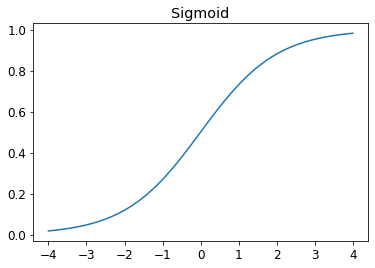

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

正如你所看到的，它接受任何输入值，正或负，并将其压缩到0到1之间的输出值上。它还是一个平滑的曲线，只会上升，这使得SGD更容易找到有意义的梯度。

让我们更新`mnist_loss`，首先将`sigmoid`应用于输入：

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

现在我们可以确信，即使预测值不在0到1之间，我们的损失函数也能正常工作。唯一需要的是，更高的预测对应于更高的置信度图像是3。

定义了损失函数，现在是回顾为什么这样做的好时机。毕竟，我们已经有了一个指标，即整体准确率。那么为什么还要定义一个损失函数呢？

关键区别在于，指标是用来驱动人类理解的，而损失函数是用来驱动自动学习的。为了驱动自动学习，损失函数必须是一个具有有意义导数的函数。它不能有大的平坦部分和大的跳跃，而必须是相当平滑的。这就是为什么我们设计了一个损失函数，它会对置信水平的微小变化做出响应。这个要求意味着有时它实际上并不能完全反映我们试图实现的目标，而是我们真正目标和一个可以使用梯度优化的函数之间的折中。损失函数是针对数据集中的每个项目进行计算的，然后在一个epoch结束时，损失值都会被平均，并且整体均值会在该epoch报告。

另一方面，指标才是我们真正关心的数字。这些是在每个epoch结束时打印的值，告诉我们我们的模型实际上的表现如何。当评估模型的性能时，我们学会专注于这些指标，而不是损失。

### SGD 和 Mini-Batches

既然我们有了一个适合驱动 SGD 的损失函数，我们可以考虑一些涉及学习过程的细节，下一步是根据梯度改变或更新权重。这称为 *优化步骤*。

为了进行优化步骤，我们需要计算一个或多个数据项的损失。我们应该使用多少数据项？我们可以对整个数据集进行计算，然后取平均值，或者可以对单个数据项进行计算。但是这两种方法都不是理想的。对整个数据集进行计算会花费很长时间。对单个数据项进行计算则不会提供足够的信息，因此会导致梯度非常不精确和不稳定。也就是说，你要费力更新权重，但只考虑了如何改进模型在单个数据项上的性能。

因此，我们在两者之间取了一个折中：我们一次计算几个数据项的平均损失。这就是所谓的 *mini-batch*。小批量中的数据项数量称为 *批量大小*。较大的批量大小意味着你将从损失函数中获得更准确和稳定的数据集梯度估计，但会花费更长时间，并且每个 epoch 处理的 mini-batches 数量更少。选择一个好的批量大小是作为深度学习从业者需要做出的决定之一，以便快速准确地训练模型。在本书中，我们将讨论如何做出这个选择。

使用 mini-batches 而不是计算单个数据项的梯度的另一个很好的理由是，在实践中，我们几乎总是在加速器（例如 GPU）上进行训练。这些加速器只有在有大量工作要做时才能发挥良好的性能，因此如果我们可以给它们大量的数据项来处理，这将很有帮助。使用 mini-batches 是实现这一目标的最佳方法之一。然而，如果一次给它们太多数据来处理，它们就会耗尽内存——让 GPU 开心也是一个棘手的问题！

正如我们在 <<chapter_production>> 中关于数据增强的讨论中看到的，如果我们在训练过程中能够变化一些东西，我们会得到更好的泛化效果。我们可以变化的一个简单有效的方法是在每个 mini-batch 中放入的数据项。与其在每个 epoch 中简单地按顺序枚举我们的数据集，不如在创建 mini-batches 之前，在每个 epoch 上对其进行随机打乱。PyTorch 和 fastai 提供了一个类，可以为你执行这个打乱和 mini-batch 集合，称为 `DataLoader`。

`DataLoader` 可以将任何 Python 集合转换为 mini-batches 的迭代器，如下所示：

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

用于训练模型时，我们不只是想要任何 Python 集合，而是一个包含独立变量和因变量（即模型的输入和目标）的集合。在 PyTorch 中，包含独立和因变量的元组的集合被称为 `Dataset`。以下是一个非常简单的 `Dataset` 示例：

In [ ]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

当我们将一个 `Dataset` 传递给 `DataLoader` 时，我们将会得到表示独立和因变量的批量的张量的元组，它们本身是小批量：

In [ ]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

我们现在可以编写第一个使用 SGD 训练模型的训练循环了！

## 将所有内容整合起来

现在是时候实现我们在<<gradient_descent>>中看到的过程了。在代码中，我们的流程将针对每个时期实现如下：

```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

首先，让我们重新初始化我们的参数：

In [ ]:
weights = init_params((28*28,1))
bias = init_params(1)

一个 `DataLoader` 可以从一个 `Dataset` 创建：

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

我们也会为验证集执行相同的操作：

In [ ]:
valid_dl = DataLoader(valid_dset, batch_size=256)

让我们创建一个大小为4的测试 mini-batch：

In [ ]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [ ]:
preds = linear1(batch)
preds

tensor([[-11.1002],
        [  5.9263],
        [  9.9627],
        [ -8.1484]], grad_fn=<AddBackward0>)

In [ ]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.5006, grad_fn=<MeanBackward0>)

现在我们可以计算梯度了：

In [ ]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0001), tensor([-0.0008]))

让我们把所有这些放在一个函数中：

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

测试一下：

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0002), tensor([-0.0015]))

但是看一下如果我们调用两次会发生什么：

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0003), tensor([-0.0023]))

梯度发生了变化！这是因为 `loss.backward` 实际上将 `loss` 的梯度添加到当前存储的任何梯度中。因此，我们必须首先将当前的梯度设置为 0：

In [ ]:
weights.grad.zero_()
bias.grad.zero_();

> 注意：原地操作：PyTorch 中名称以下划线结尾的方法会就地修改对象。例如，`bias.zero_()` 将张量 `bias` 的所有元素设置为 0。

我们唯一剩下的步骤是根据梯度和学习率更新权重和偏置。在这样做时，我们必须告诉 PyTorch 不要对此步骤的梯度进行跟踪——否则当我们尝试计算下一批次的导数时，事情会变得非常混乱！如果我们将张量的`data`属性赋值给新的张量，那么 PyTorch 将不会跟踪该步骤的梯度。下面是我们的一个基本的训练循环，用于一个 epoch：

In [ ]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

我们还想要通过查看验证集的准确性来检查我们的表现。要确定一个输出是否代表3或7，我们只需检查它是否大于0。因此，我们可以使用以下方法计算每个项目的准确性（使用广播，因此无需循环！）：

In [ ]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [ True],
        [ True],
        [False]])

这给我们提供了计算验证准确性的函数：

In [ ]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

我们可以检查它是否正常工作：

In [ ]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.5000)

然后将这些批次合并在一起：

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
validate_epoch(linear1)

0.5219

这是我们的起点。让我们训练一个周期，看看准确率是否提高了：

In [ ]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6883

然后再做几次：

In [ ]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8314 0.9017 0.9227 0.9349 0.9438 0.9501 0.9535 0.9564 0.9594 0.9618 0.9613 0.9638 0.9643 0.9652 0.9662 0.9677 0.9687 0.9691 0.9691 0.9696 

看起来不错！我们已经达到了与“像素相似度”方法大致相同的准确率，并且我们已经建立了一个通用的基础，可以在其上构建。我们的下一步将是创建一个可以为我们处理SGD步骤的对象。在PyTorch中，它被称为*优化器*。

### 创建优化器

由于这是一个非常通用的基础，PyTorch提供了一些有用的类来简化实现过程。我们可以用PyTorch的`nn.Linear`模块替换我们的`linear1`函数。*模块*是一个从PyTorch的`nn.Module`类继承的类的对象。这个类的对象与标准的Python函数表现相同，你可以使用括号调用它们，它们将返回模型的激活。

`nn.Linear`做的事情与我们的`init_params`和`linear`函数相同。它将*权重*和*偏置*都包含在一个单独的类中。下面是如何复制上一节中的模型：

In [ ]:
linear_model = nn.Linear(28*28,1)

每个PyTorch模块都知道它具有哪些可以训练的参数；它们可以通过`parameters`方法获得：

In [ ]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

我们可以利用这些信息来创建一个优化器：

In [ ]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

我们可以通过传入模型的参数来创建优化器：

In [ ]:
opt = BasicOptim(linear_model.parameters(), lr)

我们的训练循环现在可以简化为：

In [ ]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

我们的验证函数根本不需要更改：

In [ ]:
validate_epoch(linear_model)

0.4157

让我们把我们的小训练循环放在一个函数中，以简化操作：

In [ ]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

结果与上一节相同：

In [ ]:
train_model(linear_model, 20)

0.4932 0.8618 0.8203 0.9102 0.9331 0.9468 0.9555 0.9629 0.9658 0.9673 0.9687 0.9707 0.9726 0.9751 0.9761 0.9761 0.9775 0.978 0.9785 0.9785 

fastai提供了`SGD`类，默认情况下与我们的`BasicOptim`做的事情相同：

In [ ]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.852 0.8335 0.9116 0.9326 0.9473 0.9555 0.9624 0.9648 0.9668 0.9692 0.9712 0.9731 0.9746 0.9761 0.9765 0.9775 0.978 0.9785 0.9785 

fastai还提供了`Learner.fit`，我们可以使用它来代替`train_model`。要创建一个`Learner`，我们首先需要创建一个`DataLoaders`，通过传入我们的训练和验证`DataLoader`s：

In [ ]:
dls = DataLoaders(dl, valid_dl)

要创建一个`Learner`，而不是使用应用程序（比如`vision_learner`），我们需要传入本章中创建的所有元素：`DataLoaders`、模型、优化函数（将传递参数）、损失函数，以及可选的任何要打印的指标：

In [ ]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

现在我们可以调用 `fit`：

In [ ]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636857,0.503549,0.495584,00:00
1,0.545725,0.170281,0.866045,00:00
2,0.199223,0.184893,0.831207,00:00
3,0.086580,0.107836,0.911187,00:00
4,0.045185,0.078481,0.932777,00:00
5,0.029108,0.062792,0.946516,00:00
6,0.022560,0.053017,0.955348,00:00
7,0.019687,0.046500,0.962218,00:00
8,0.018252,0.041929,0.965162,00:00
9,0.017402,0.038573,0.967615,00:00


正如你所看到的，PyTorch和fastai类并没有什么神奇之处。它们只是方便的预打包组件，使你的生活变得更加轻松！（它们还提供了我们将在未来章节中使用的许多额外功能。）

有了这些类，我们现在可以用神经网络替换我们的线性模型。

## 添加非线性

到目前为止，我们已经有了一个优化函数参数的通用流程，并且已经在一个非常无聊的函数上尝试过它：一个简单的线性分类器。线性分类器在能做的事情方面非常受限。为了使其更复杂一些（并且能够处理更多的任务），我们需要在两个线性分类器之间添加一些非线性的东西——这就是给我们一个神经网络的东西。

这是一个基本神经网络的整体定义：

In [ ]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

这就是全部！在`simple_net`中，我们只有两个线性分类器，并且它们之间有一个`max`函数。

在这里，`w1`和`w2`是权重张量，`b1`和`b2`是偏置张量；也就是说，它们是初始随机初始化的参数，就像我们在上一节中所做的一样：

In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

关键点在于`w1`有30个输出激活（这意味着`w2`必须有30个输入激活，以便它们匹配）。这意味着第一层可以构建30个不同的特征，每个特征代表一些不同的像素混合。你可以将`30`改成任何你喜欢的数字，以使模型更复杂或更简单。

这个小函数`res.max(tensor(0.0))`被称为*修正线性单元*，也称为*ReLU*。我们都认为*修正线性单元*听起来相当花哨和复杂... 但实际上，它的实质就是`res.max(tensor(0.0))`——也就是说，将每个负数替换为零。这个微小的函数在PyTorch中也可以用`F.relu`表示：

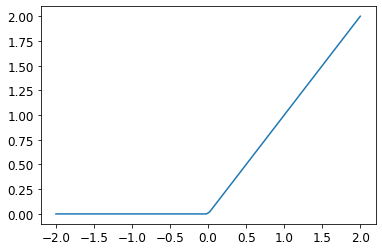

In [ ]:
plot_function(F.relu)

> 术语: 深度学习中有大量的术语，包括诸如_修正线性单元_之类的术语。绝大多数这些术语并不比我们在这个例子中看到的更复杂。事实是，学术界为了发表论文，他们需要让论文听起来尽可能令人印象深刻和复杂。他们做到这一点的方式之一就是引入行话。不幸的是，这导致该领域变得比应该更加令人望而生畏和难以进入。你确实需要学习行话，因为否则论文和教程对你来说意义不大。但这并不意味着你必须觉得行话令人生畏。只需记住，当你遇到之前没见过的单词或短语时，它几乎肯定是在指代一个非常简单的概念。

基本思想是通过使用更多的线性层，我们的模型可以进行更多的计算，因此可以建模更复杂的函数。但是，直接将一个线性层放在另一个线性层后面没有意义，因为当我们将多个数相乘然后相加多次时，可以用将不同的数相乘然后相加一次来代替！换句话说，连续任意数量的线性层可以用具有不同参数集的单个线性层来替换。

但是，如果我们在它们之间放置一个非线性函数，比如`max`，那么情况就不再如此。现在，每个线性层实际上在某种程度上与其他线性层解耦，并且可以执行自己的有用工作。`max`函数特别有趣，因为它作为一个简单的`if`语句。

> S: 从数学上讲，我们说两个线性函数的组合是另一个线性函数。因此，我们可以将尽可能多的线性分类器堆叠在一起，如果它们之间没有非线性函数，那么结果将与一个线性分类器相同。

令人惊奇的是，数学上可以证明，如果你能找到合适的参数`w1`和`w2`，并且使这些矩阵足够大，那么这个小函数可以以任意高的精度解决任何可计算的问题。对于任何任意振荡的函数，我们可以将其近似为一堆连接在一起的直线；要使其更接近于振荡函数，我们只需使用更短的直线。这被称为*通用逼近定理*。我们在这里有三行代码，它们被称为*层*。第一行和第三行被称为*线性层*，第二行代码被称为*非线性*或*激活函数*。

就像前面的部分一样，我们可以利用PyTorch来用更简单的方式替换这段代码：

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

`nn.Sequential`创建了一个模块，它会依次调用列出的每个层或函数。

`nn.ReLU`是一个PyTorch模块，其功能与`F.relu`函数完全相同。大多数可以出现在模型中的函数也有相同的模块形式。通常只需将`F`替换为`nn`并更改大写。在使用`nn.Sequential`时，PyTorch要求我们使用模块版本。由于模块是类，我们必须实例化它们，这就是为什么在这个示例中你看到`nn.ReLU()`。

由于`nn.Sequential`是一个模块，我们可以获取它的参数，它会返回它包含的所有模块的所有参数的列表。让我们试试看！由于这是一个更深的模型，我们将使用较低的学习率和更多的epochs。

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
#hide_output
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.305828,0.399663,0.508341,00:00
1,0.142960,0.225702,0.807655,00:00
2,0.079516,0.113519,0.919529,00:00
3,0.052391,0.076792,0.943081,00:00
4,0.039796,0.060083,0.956330,00:00
5,0.033368,0.050713,0.963690,00:00
6,0.029680,0.044797,0.965653,00:00
7,0.027290,0.040729,0.968106,00:00
8,0.025568,0.037771,0.968597,00:00
9,0.024233,0.035508,0.970559,00:00


我们这里没有显示40行输出，以节省空间；训练过程记录在`learn.recorder`中，输出表格存储在`values`属性中，因此我们可以绘制训练期间的准确性如下：

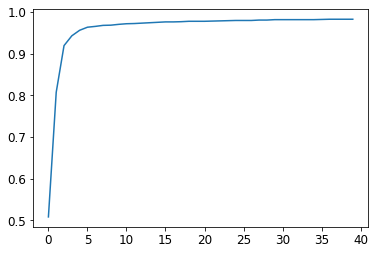

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

我们可以查看最终准确性：

In [ ]:
learn.recorder.values[-1][2]

0.982826292514801

此时，我们拥有了一些非常神奇的东西：

1. 一个可以根据正确的参数集解决任何问题并达到任何精度的函数（神经网络）
2. 一种寻找任何函数的最佳参数集的方法（随机梯度下降）

这就是为什么深度学习可以做一些看起来相当神奇的事情的原因。相信这些简单技术的组合真的可以解决任何问题是许多学生必须迈出的最重要的一步之一。这似乎太美好了，以至于令人难以置信——事情难道不应该比这更困难和复杂吗？我们的建议是：尝试一下！我们刚刚在MNIST数据集上尝试了它，你已经看到了结果。而且由于我们自己从头开始做了一切（除了计算梯度），所以你知道背后没有隐藏任何特殊的魔法。

### 进一步深入

不仅仅局限于两个线性层，我们可以添加任意数量的线性层，只要在每对线性层之间添加一个非线性。然而，正如你将学到的，模型变得越深，实际中优化参数就越困难。在本书的后面，你将学习到一些简单但非常有效的技术，用于训练更深的模型。

我们已经知道，一个具有两个线性层的单一非线性就足以近似任何函数。那么为什么要使用更深的模型呢？原因在于性能。通过使用更深的模型（即具有更多层的模型），我们不需要使用太多参数；事实证明，我们可以使用更小的矩阵和更多层，获得比使用更大的矩阵和更少层更好的结果。

这意味着我们可以更快地训练模型，并且它将占用更少的内存。在上世纪90年代，研究人员对于通用逼近定理如此专注，以至于很少有人在使用多个非线性进行实验。这种理论上但不是实际上的基础使该领域停滞了数年。然而，一些研究人员确实尝试了深层模型，并最终能够证明这些模型在实践中的性能要好得多。最终，人们发展出了理论结果，解释了为什么会发生这种情况。如今，几乎没有人会使用只有一个非线性的神经网络。

下面是使用与<<chapter_intro>>中相同方法训练18层模型时发生的情况：

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.082089,0.009578,0.997056,00:11


几乎100%的准确率！与我们的简单神经网络相比，这是一个很大的差异。但正如你在本书的后续部分中将学到的，你只需要使用一些小技巧就能自己从头开始获得如此好的结果。你已经了解了关键的基础知识。（当然，即使你知道了所有的技巧，你也几乎总是希望使用PyTorch和fastai提供的预构建类，因为它们可以帮助你省去思考所有细节的麻烦。）

## 术语回顾

恭喜你：你现在知道如何从头开始创建和训练一个深度神经网络了！我们经历了很多步骤才达到这一点，但你可能会惊讶于它实际上有多么简单。

既然我们已经到了这一步，现在是一个很好的机会来定义和复习一些行话和关键概念。

神经网络包含很多数字，但它们只有两种类型：计算得到的数字，和这些数字所计算得来的参数。这给我们提供了两个最重要的行话：

- 激活：计算得到的数字（线性和非线性层都有）
- 参数：随机初始化的数字，并进行优化（即定义模型的数字）

我们在本书中经常会谈论激活和参数。记住它们具有非常具体的含义。它们是数字。它们不是抽象的概念，而是你的模型中实际的具体数字。成为一名优秀的深度学习从业者的一部分就是习惯于实际查看你的激活和参数，并绘制它们，并测试它们是否 behaving 正确。

我们的激活和参数都包含在 *张量* 中。这些只是定期形状的数组—例如，一个矩阵。矩阵有行和列；我们称之为 *轴* 或 *维度*。张量的维数是它的 *秩*。有一些特殊的张量：

- 秩零：标量
- 秩一：向量
- 秩二：矩阵

神经网络包含许多层。每一层都是 *线性* 的或 *非线性* 的。我们通常在神经网络中交替使用这两种类型的层。有时人们将一个线性层及其后续的非线性一起称为一个单独的层。是的，这很令人困惑。有时非线性被称为 *激活函数*。

<<dljargon1>> 总结了与 SGD 相关的关键概念。

```asciidoc
[[dljargon1]]
.深度学习词汇表
[options="header"]
|=====
| 术语 | 含义
|ReLU | 对负数返回0，并不改变正数的函数。
|Mini-batch | 一个小组输入和标签，它们以两个数组的形式聚集在一起。梯度下降步骤是在这个批处理上更新的（而不是整个时期）。
|Forward pass | 将模型应用于某些输入并计算预测。
|Loss | 表示我们的模型表现如何（好或坏）的值。
|Gradient | 相对于模型某个参数的损失的导数。
|Backward pass | 计算损失相对于所有模型参数的梯度。
|Gradient descent | 沿着梯度的相反方向迈出一步，使模型参数稍微变得更好。
|Learning rate | 在应用 SGD 更新模型参数时所采取的步长大小。
|=====
```

> note: _Choose Your Own Adventure_ Reminder: Did you choose to skip over chapters 2 & 3, in your excitement to peek under the hood? Well, here's your reminder to head back to chapter 2 now, because you'll be needing to know that stuff very soon!

## 问卷调查

1. 灰度图像在计算机上是如何表示的？彩色图像呢？
2. `MNIST_SAMPLE` 数据集中的文件和文件夹是如何组织的？为什么这样组织？
3. 解释一下“像素相似度”方法如何用于分类数字。
4. 什么是列表推导式？现在创建一个，从列表中选择奇数并使它们翻倍。
5. 什么是“三维张量”？
6. 张量秩和形状之间有什么区别？如何从形状中获取秩？
7. RMSE和L1范数是什么？
8. 如何一次性对成千上万的数字进行计算，速度比Python循环快数千倍？
9. 创建一个3×3的张量或数组，包含从1到9的数字。将其翻倍。选择右下角的四个数字。
10. 什么是广播？
11. 指标通常是用训练集还是验证集来计算的？为什么？
12. 什么是SGD？
13. SGD为什么使用小批量？
14. 机器学习中SGD的七个步骤是什么？
15. 我们如何在模型中初始化权重？
16. 什么是“损失”？
17. 为什么我们不能总是使用高学习率？
18. 什么是“梯度”？
19. 你需要自己知道如何计算梯度吗？
20. 为什么我们不能使用准确率作为损失函数？
21. 画出sigmoid函数。它的形态有什么特别之处？
22. 损失函数和指标之间有什么区别？
23. 使用学习率计算新权重的函数是什么？
24. `DataLoader` 类是做什么的？
25. 写出伪代码，展示SGD每个时代的基本步骤。
26. 创建一个函数，如果传入两个参数`[1,2,3,4]`和`'abcd'`，返回`[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`。这个输出数据结构有什么特别之处？
27. 在PyTorch中，`view`是做什么的？
28. 神经网络中的“偏置”参数是什么？为什么我们需要它们？
29. Python中的`@`操作符是做什么的？
30. `backward`方法做什么？
31. 为什么我们必须将梯度归零？
32. 我们必须向`Learner`传递哪些信息？
33. 展示Python或伪代码，用于训练循环的基本步骤。
34. “ReLU”是什么？为从`-2`到`+2`的值绘制一个图表。
35. 什么是“激活函数”？
36. `F.relu`和`nn.ReLU`之间有什么区别？
37. 通用近似定理表明，任何函数都可以使用仅一个非线性逼近到所需的精度。那么为什么我们通常使用更多？

### 进一步的研究

1. 根据本章展示的训练循环，从头开始创建你自己的 `Learner` 实现。
2. 使用完整的MNIST数据集（即，对所有数字进行处理，不仅仅是3和7）完成本章的所有步骤。这是一个重要的项目，完成它需要相当长的时间！你将需要进行一些自己的研究，以找出如何克服途中遇到的一些障碍。